<img src="../LogoUTN.jpg" align="right" width="150" /> 

### Procesamiento Digital de Señales - 2024

# Trabajo Práctico Nº7: Estimación espectral: Ancho de banda de señales
### Juan Manuel Ronchetti

## Introduccion

En el repositorio de la catedra se proveen tres tipos de señales registradas:

* Electrocardiograma (ECG)
* Pletismografía (PPG)
* Audio

Se pide realizar una estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase.

Adicionalmente, se pide:
* Compare el método que haya elegido con los demás vistos: Periodograma ventaneado, Welch, Blackman-Tukey
* Realice una estimación del ancho de banda de cada señal

## Preparacion de la simulacion

In [15]:
# -------------------------------------------------------------------------------
#                                   Imports
# -------------------------------------------------------------------------------

import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------------------
#                                Lectura de datos
# -------------------------------------------------------------------------------

# ---------- Lectura de ECG 

fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg = (mat_struct['ecg_lead']).flatten()
s_ecg = ecg[:9999]

# ---------- Lectura de PPG

fs_ppg = 400  # Hz
ppg = np.genfromtxt('PPG.csv', delimiter=',', skip_header=1) 

# ---------- Lectura de audio 

fs_audio, wav_data = sio.wavfile.read('silbido.wav')
if wav_data.ndim > 1:
    wav_data = wav_data[:, 0]  # Usar solo un canal si es estéreo
    
# -------------------------------------------------------------------------------
#                      Funcion para estimar con Blackman-Tukey
# -------------------------------------------------------------------------------

def blackman_tukey(x, fs, M=None):    
    x_z = x.shape
    N = np.max(x_z)
    
    if M is None:
        M = N // 5
    
    r_len = 2 * M - 1
    xx = x.ravel()[:r_len]
    
    r = np.correlate(xx, xx, mode='same') / r_len
    Px = np.abs(np.fft.fft(r * sig.windows.blackman(r_len), n=N))
    
    freq = np.fft.fftfreq(N, 1/fs)
    
    return freq, Px

# -------------------------------------------------------------------------------
#                          Funcion para obtener ancho de banda
# -------------------------------------------------------------------------------

def estimate_bandwidth(frequencies, psd):
    total_energy = np.sum(psd)
    energy_threshold = 0.99 * total_energy
    
    cumulative_energy = np.cumsum(psd)
    
    lower_limit_index = np.where(cumulative_energy >= (total_energy - energy_threshold))[0][0]
    upper_limit_index = np.where(cumulative_energy >= energy_threshold)[0][0]

    bandwidth = frequencies[upper_limit_index] - frequencies[lower_limit_index]
    central_frequency = (frequencies[lower_limit_index] + frequencies[upper_limit_index]) / 2
    
    return bandwidth, central_frequency, frequencies[lower_limit_index], frequencies[upper_limit_index]

## Simulacion

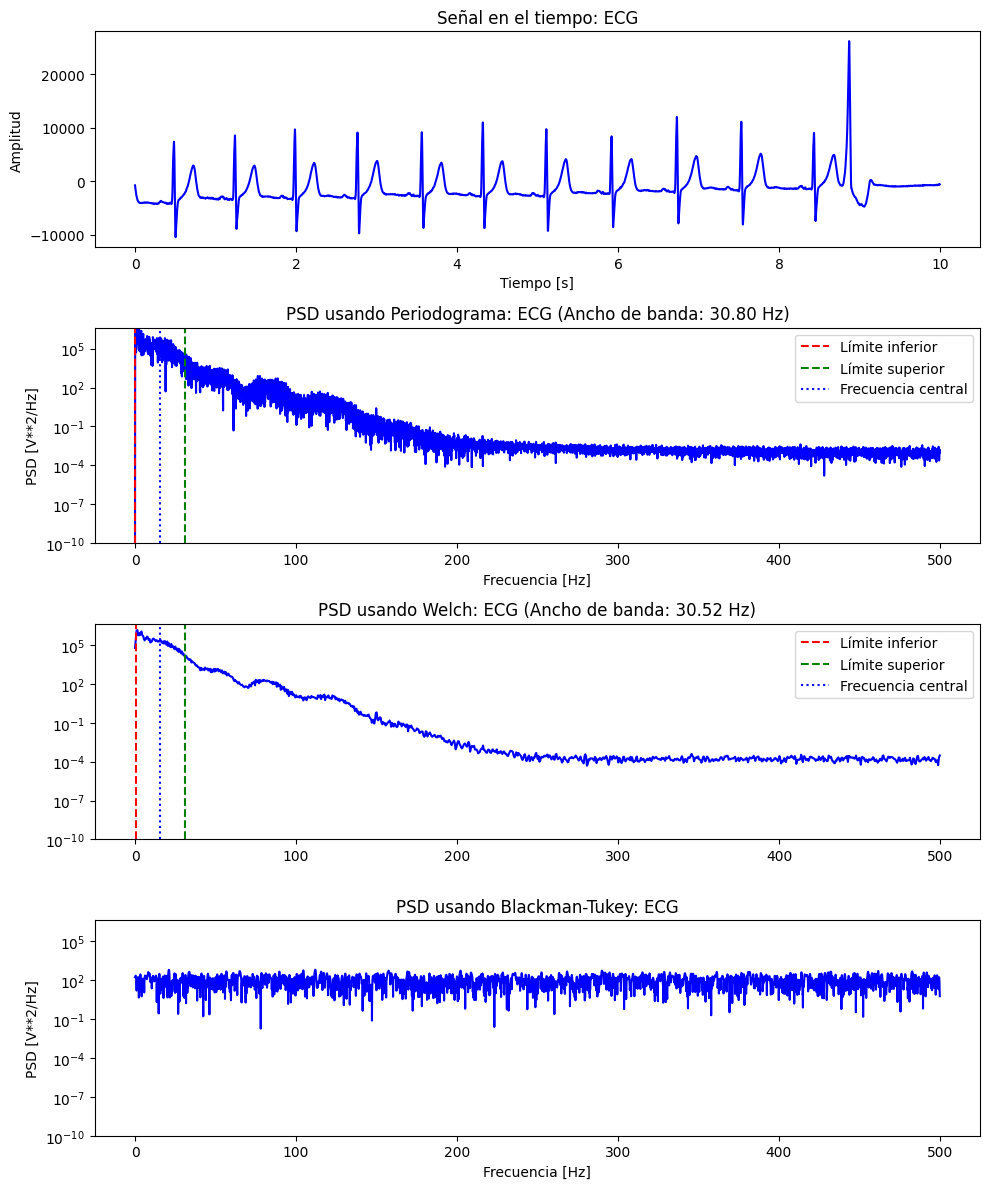

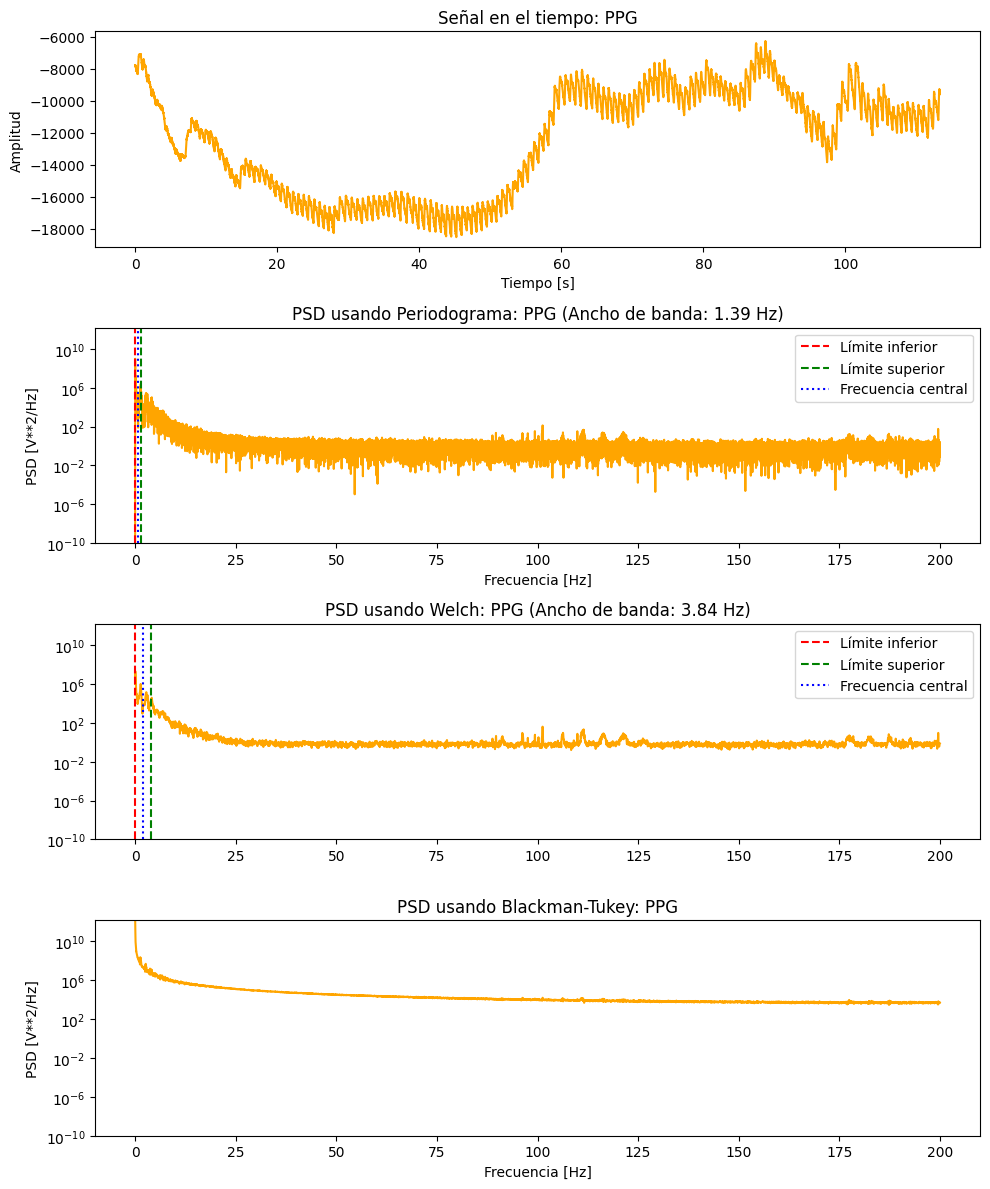

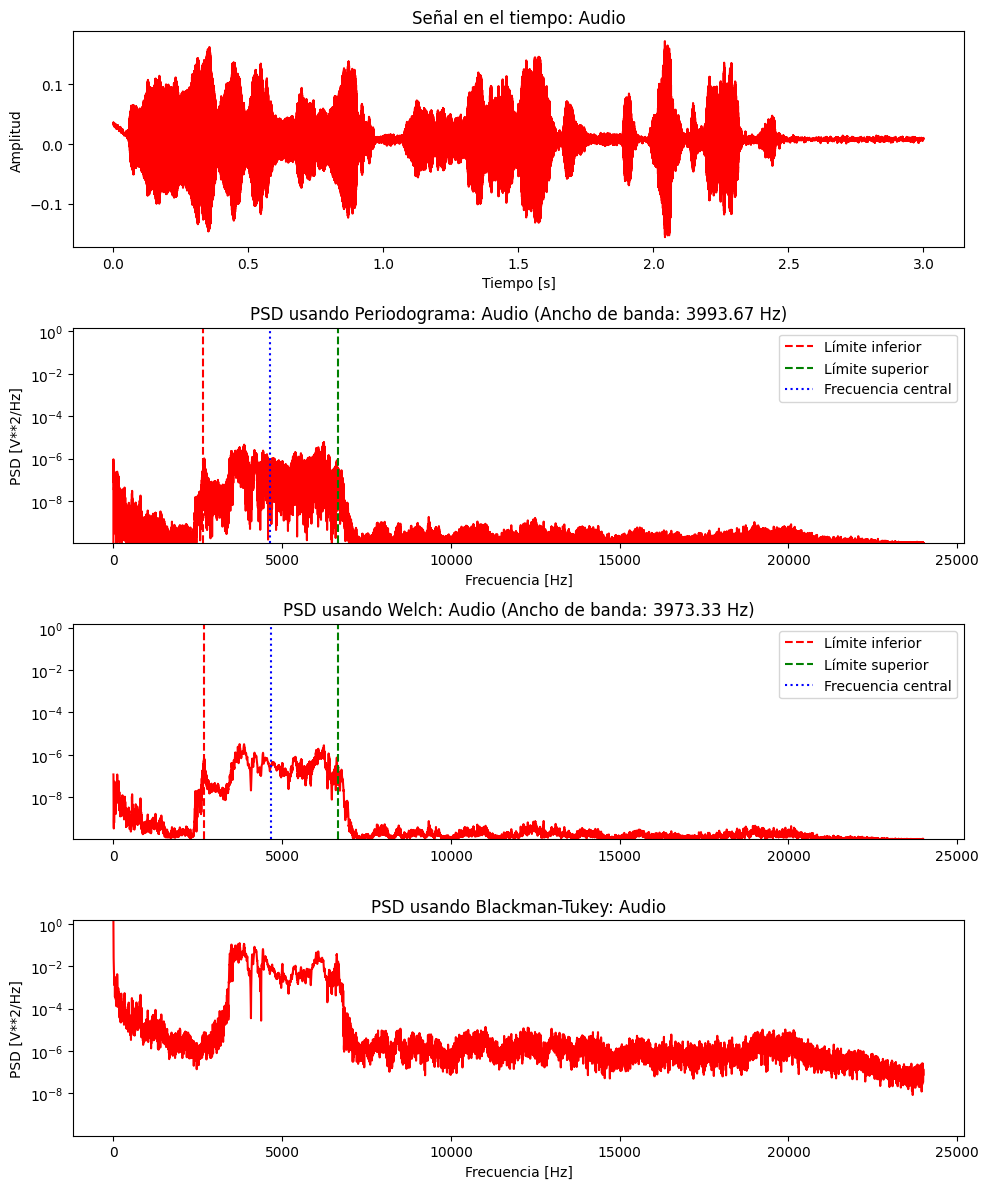

In [26]:
# -------------------------------------------------------------------------------
#                      Funcion para obtener y graficar la PSD
# -------------------------------------------------------------------------------

# Para almacenar y mostrar al final
resultados = []

def append_result(signal, method, bw, fc, f1, f2):
    resultados.append({
        'Señal': signal,
        'Metodo': method,
        'Ancho de Banda (Hz)': bw,
        'Frecuencia Central (Hz)': fc,
        'Límite Inferior (Hz)': f1,
        'Límite Superior (Hz)': f2
    })

def plot_signal_and_psd(signal, fs, title, color = 'black'):
    N = len(signal)
    
    # --------- Periodograma
    f_periodogram, Pxx_periodogram = sig.periodogram(signal, fs)
    
    bandwidth_p, central_freq_p, lower_freq_p, upper_freq_p = estimate_bandwidth(f_periodogram, Pxx_periodogram)
    append_result(title, 'Periodograma', bandwidth_p, central_freq_p, lower_freq_p, upper_freq_p )
    
    # --------- Welch
    nperseg = N // 5 
    noverlap = nperseg // 2
    f_welch, Pxx_welch = sig.welch(signal, fs, nperseg=nperseg, noverlap=noverlap)
    
    bandwidth_welch, central_freq_welch, lower_freq_welch, upper_freq_welch = estimate_bandwidth(f_welch, Pxx_welch)
    append_result(title, 'Welch', bandwidth_welch, central_freq_welch, lower_freq_welch, upper_freq_welch )
    
    # --------- Blackman-Tukey
    f_bt, Pxx_bt = blackman_tukey(signal, fs)
    bfrec_bt = f_bt >= 0

    #bandwidth_bt, central_freq_bt, lower_freq_bt, upper_freq_bt = estimate_bandwidth(f_bt[:1000], Pxx_bt[:1000])
    #append_result(title, 'Blackman-Tukey', bandwidth_bt, central_freq_bt, lower_freq_bt, upper_freq_bt )

    # --------- Obtener limites Y para unificar
    all_psd_values = np.concatenate([Pxx_periodogram, Pxx_welch, Pxx_bt[bfrec_bt]])
    all_psd_values += 1e-10 
    y_min, y_max = np.min(all_psd_values), np.max(all_psd_values)

    
    
    # Crear la figura y los ejes
    fig, axs = plt.subplots(4, 1, figsize=(10, 12))
    plt.subplots_adjust(hspace=0.5)  # Espacio entre los subgráficos

    # --------- Gráfico de la señal en el tiempo
    axs[0].plot(np.arange(len(signal)) / fs, signal, color = color)
    axs[0].set_title(f'Señal en el tiempo: {title}')
    axs[0].set_xlabel('Tiempo [s]')
    axs[0].set_ylabel('Amplitud')

    # --------- Gráfico del periodograma
    axs[1].semilogy(f_periodogram, Pxx_periodogram + 1e-10, color=color)  # Evitar log(0)
    axs[1].set_title(f'PSD usando Periodograma: {title} (Ancho de banda: {bandwidth_p:.2f} Hz)')
    axs[1].set_xlabel('Frecuencia [Hz]')
    axs[1].set_ylabel('PSD [V**2/Hz]')
    axs[1].axvline(lower_freq_p, color='r', linestyle='--', label='Límite inferior')
    axs[1].axvline(upper_freq_p, color='g', linestyle='--', label='Límite superior')
    axs[1].axvline(central_freq_p, color='b', linestyle=':', label='Frecuencia central')
    axs[1].set_ylim(y_min, y_max)
    axs[1].legend()

    # --------- Gráfico de Welch
    axs[2].semilogy(f_welch, Pxx_welch + 1e-10, color = color)  # Evitar log(0)
    axs[2].set_title(f'PSD usando Welch: {title} (Ancho de banda: {bandwidth_welch:.2f} Hz)')
    axs[2].axvline(lower_freq_welch, color='r', linestyle='--', label='Límite inferior')
    axs[2].axvline(upper_freq_welch, color='g', linestyle='--', label='Límite superior')
    axs[2].axvline(central_freq_welch, color='b', linestyle=':', label='Frecuencia central')
    axs[2].legend()
    axs[2].set_ylim(y_min, y_max)
    
    # --------- Gráfico de Blackman-Tukey
    axs[3].semilogy(f_bt[bfrec_bt], Pxx_bt[bfrec_bt] + 1e-10, color = color)  # Evitar log(0)
    axs[3].set_title(f'PSD usando Blackman-Tukey: {title}') # (Ancho de banda: {bandwidth_bt:.2f} Hz)')
    axs[3].set_xlabel('Frecuencia [Hz]')
    axs[3].set_ylabel('PSD [V**2/Hz]')
    #axs[3].axvline(lower_freq_bt, color='r', linestyle='--', label='Límite inferior')
    #axs[3].axvline(upper_freq_bt, color='g', linestyle='--', label='Límite superior')
    #axs[3].axvline(central_freq_bt, color='b', linestyle=':', label='Frecuencia central')
    axs[3].set_ylim(y_min, y_max)
    #axs[3].legend()
    
    plt.tight_layout()
    plt.show()
    

# -------------------------------------------------------------------------------
#                       Llamado a la funcion de PSD
# -------------------------------------------------------------------------------

plot_signal_and_psd(s_ecg, fs_ecg, 'ECG', color = 'blue')
plot_signal_and_psd(ppg, fs_ppg, 'PPG', color = 'orange')
plot_signal_and_psd(wav_data, fs_audio, 'Audio', color = 'red')

## Tabla de resultados

In [27]:
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by=['Señal'], inplace=True)
styled_table = df_resultados.style.hide(axis="index").format(precision=3)
styled_table

Señal,Metodo,Ancho de Banda (Hz),Frecuencia Central (Hz),Límite Inferior (Hz),Límite Superior (Hz)
Audio,Periodograma,3993.667,4653.833,2657.000,6650.667
Audio,Welch,3973.333,4668.333,2681.667,6655.000
ECG,Periodograma,30.803,15.502,0.100,30.903
ECG,Welch,30.515,15.758,0.500,31.016
PPG,Periodograma,1.395,0.706,0.009,1.403
PPG,Welch,3.840,1.920,0.000,3.840


## Analisis y conclusiones
Dadas las tres señales reales provistas, fue posible procesarlas y visualizarlas en el entorno de python. Se obtuvieron las señales en tiempo, donde se observaron las caracteristicas de señales reales.

A su vez, fue posible estimar la Densidad Espectral de Potencia (PSD) de cada una utilizando tres metodos distintos:
 * Periodograma
 * Welch
 * Blackman-Tukey

Finalmente, se estimó el ancho de banda de cada señal, analizando el resultado para cada metodo aplicado. 

En base al analisis, se observaron las siguientes conclusiones:
 * El mejor metodo para este tipo de estimacion resulto el de Welch. Con este se obtuvieron los graficos mas precisos, y las mejores estimaciones de ancho de banda. Demuestra ser superior al Periodograma, gracias a su mayor complejidad algoritmica.
 * El metodo Blackman-Tukey sirvió para obtener una idea de la estimacion de la PSD, pero las estimaciones presentaron errores en comparacion con los otros dos metodos. Esto puede deberse al algoritmo empleado, el cual puede ser mejorado.